<a href="https://colab.research.google.com/github/tramyynt/Techlabs/blob/master/Kopie_von_Pickshare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas
import pandas as pd
import json
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.graph_objects as go
import geopandas as gpd
import geopy
plt.style.use('seaborn')

from google.colab import drive
%matplotlib inline

     |████████████████████████████████| 1.0 MB 4.9 MB/s 
     |████████████████████████████████| 6.3 MB 31.1 MB/s 
     |████████████████████████████████| 15.4 MB 34 kB/s 


In [ ]:
drive.mount('/drive')

Mounted at /drive


In [ ]:
users = pd.read_json('/drive/MyDrive/Techlabs/users.json')
users.head(5)
packages = pd.read_json('/drive/MyDrive/Techlabs/packages.json')
packages.head(5)

,senderCompanyName,city,start,end,createdAt,_owner,deliveryDate
0,Amazon,Dortmund,10:00,14:00,2020-07-10T12:40:31.189Z,1,NaN
1,Zoo Royal,Berlin,NaN,NaN,2020-07-21T17:05:11.366Z,31,NaN
2,ABOUTYOU,Dortmund,NaN,NaN,2020-07-22T10:55:39.592Z,1,NaN
3,Test,Berlin,NaN,NaN,2020-07-27T10:22:23.430Z,7,NaN
4,notebooksbilliger.de,Dortmund,1800,2000,2020-08-06T14:47:47.813Z,1,NaN


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(packages['_owner'].describe())
print(packages['city'].describe())
print(users['firstName'].describe())
print(users['city'].describe())

count    3710.00000
mean       50.85283
std        48.87821
min         0.00000
25%        18.00000
50%        33.00000
75%        66.00000
max       324.00000
Name: _owner, dtype: float64
count       3649
unique        42
top       Berlin
freq        2633
Name: city, dtype: object
count      326
unique     257
top       Test
freq         5
Name: firstName, dtype: object
count        326
unique        85
top       Berlin
freq         120
Name: city, dtype: object


In [ ]:
print(packages['senderCompanyName'].describe())

count       3710
unique      1011
top       Amazon
freq        1109
Name: senderCompanyName, dtype: object


1. Cluster geospatial data to know where we should put a depot
2. Cluster based on their total numbers of oders.

### Data Preprocessing

In [ ]:
def  cleaning_text(df, col):
  df.loc[df[col].str.contains('berlin', case=False, regex=False), col] = 'Berlin'
  df.loc[df[col].str.contains('dortmund', case=False, regex=False), col] = 'Dortmund'
  df.loc[df[col].str.contains('Potsdam', case=False, regex=False), col] = 'Potsdam'
  df.loc[df[col].str.contains('Dusseldorf', case=False, regex=False), col] = 'Düsseldorf'
  df.loc[df[col].str.contains('Regensburg', case=False, regex=False), col] = 'Regensburg'
  df.loc[df[col].str.contains('Moenchengladbach', case = False, regex = False), col] = 'Mönchengladbach'
  df.loc[df[col].str.contains('Bad Hersfeld', case = False, regex = False), col] = 'Bad Hersfeld'
  df.loc[df[col].str.contains('Viersen', case = False, regex = False), col] = 'Viersen'
  df.loc[df[col].str.contains('Münster', case = False, regex = False), col] = 'Münster'
  df.loc[df[col].str.contains('mönchengladbach', case = False, regex = False), col] = 'Mönchengladbach'
  df.loc[df[col].str.contains('Wetzlar', case = False, regex = False), col] = 'Wetzlar'
  df.loc[df[col].str.contains('München', case = False, regex = False), col] = 'München'
  return df

In [ ]:
#packages
#packages.isna().sum()
packages = packages[packages.city.notna()].reset_index(drop=True) #remove missing values

#cleaning text
packages = cleaning_text(packages, 'city')

In [ ]:
#users
users = users[users.city.notna()].reset_index(drop = True)

users = cleaning_text(users,'city')

In [ ]:
#get city list of Germany and check if a city belongs to the list, otherwise remove it. Refer : https://moduliertersingvogel.de/2017/09/03/german-cities-list/
from bs4 import BeautifulSoup
import requests
class CityList:
    def __init__(self):
        self.__countries={
            'BY':'Bayern',
            'BW':'Baden-Württemberg',
            'NW':'Nordrhein-Westfalen',
            'HE':'Hessen',
            'SN':'Sachsen',
            'NI':'Niedersachsen',
            'RP':'Rheinland-Pfalz',
            'TH':'Thüringen',
            'BB':'Brandenburg',
            'ST':'Sachsen-Anhalt',
            'MV':'Mecklenburg-Vorpommern',
            'SH':'Schleswig-Holstein',
            'SL':'Saarland',
            'HB':'Bremen',
            'BE':'Berlin',
            'HH':'Hamburg'
        }
        
    def retrieveGermanList(self):
        r = requests.get('https://de.wikipedia.org/wiki/Liste_der_St%C3%A4dte_in_Deutschland')
        soup = BeautifulSoup(r.content, "html5lib")
        cities={}
        tables=soup.find_all('table')
        for t in tables:
            lis=t.find_all('dd')
            for l in lis:
                # All countries are in brackets after the city name.
                # Some cities are listed like: SN, Landeshauptstadt
                countryShort=None
                additional=l.contents[1].split('(')[1].split(')')[0].strip()
                if ',' in additional:
                    countryShort=additional.split(',')[0]
                else:
                    countryShort=additional
                cities[l.find('a').contents[0]]=self.__countries[countryShort]
                
        return cities

city_list = CityList().retrieveGermanList()
users = users[users['city'].isin(city_list.keys())]
packages = packages[packages['city'].isin(city_list.keys())]

In [ ]:
users_per_city = users['city'].value_counts().to_frame().reset_index(drop = False)
users_per_city.columns = ['city', 'number_users']
users_per_city['federal'] = users_per_city['city'].apply(lambda x: city_list[x])
users_per_city['percentage_user'] = users_per_city['number_users']*100/users_per_city['number_users'].sum()
users_per_city

,city,number_users,federal,percentage_user
0,Berlin,132,Berlin,45.205479
1,Dortmund,45,Nordrhein-Westfalen,15.410959
2,Mönchengladbach,29,Nordrhein-Westfalen,9.931507
3,Wetzlar,14,Hessen,4.794521
4,Münster,12,Nordrhein-Westfalen,4.109589
5,Regensburg,7,Bayern,2.397260
6,Potsdam,5,Brandenburg,1.712329
7,München,4,Bayern,1.369863
8,Bad Hersfeld,4,Hessen,1.369863
9,Düsseldorf,4,Nordrhein-Westfalen,1.369863


In [ ]:
packages_per_city = packages['city'].value_counts().to_frame().reset_index(drop=False)
packages_per_city.columns = ['city','num_packages']
packages_per_city['federal'] = packages_per_city['city'].apply(lambda x: city_list[x]) 
packages_per_city

,city,num_packages,federal
0,Berlin,3070,Berlin
1,Dortmund,280,Nordrhein-Westfalen
2,Münster,54,Nordrhein-Westfalen
3,Wetzlar,53,Hessen
4,Regensburg,41,Bayern
5,Mönchengladbach,26,Nordrhein-Westfalen
6,Potsdam,21,Brandenburg
7,Düsseldorf,10,Nordrhein-Westfalen
8,Bad Hersfeld,5,Hessen
9,Grevenbroich,4,Nordrhein-Westfalen


In [ ]:
packages_per_city['percentage'] = packages_per_city['num_packages']*100/packages_per_city['num_packages'].sum()

In [ ]:
packages_per_city

,city,num_packages,federal,percentage
0,Berlin,3070,Berlin,85.634589
1,Dortmund,280,Nordrhein-Westfalen,7.810321
2,Münster,54,Nordrhein-Westfalen,1.506276
3,Wetzlar,53,Hessen,1.478382
4,Regensburg,41,Bayern,1.143654
5,Mönchengladbach,26,Nordrhein-Westfalen,0.725244
6,Potsdam,21,Brandenburg,0.585774
7,Düsseldorf,10,Nordrhein-Westfalen,0.278940
8,Bad Hersfeld,5,Hessen,0.139470
9,Grevenbroich,4,Nordrhein-Westfalen,0.111576


In [ ]:
pack_per_city = packages_per_city.copy()
pack_per_city = pack_per_city.drop(columns = 'federal')

## Exploratory Data Analysis
1. Number of packages per city 
2. Number of users per city
3. Number of packages per sender

### **1.  Cities have the most orders**

In [ ]:
#get Geman map
plz_ort = pd.read_csv('/content/drive/MyDrive/Techlabs/zuordnung_plz_ort.csv',sep=',', dtype={'plz': str})
plz_ort.drop('osm_id', axis=1, inplace=True)
plz_ort.head(5)
#!unzip /content/drive/MyDrive/Techlabs/plz-gebiete.shp.zip  -d /content/drive/MyDrive/Techlabs

,ort,plz,bundesland
0,Aach,78267,Baden-Württemberg
1,Aach,54298,Rheinland-Pfalz
2,Aachen,52062,Nordrhein-Westfalen
3,Aachen,52064,Nordrhein-Westfalen
4,Aachen,52066,Nordrhein-Westfalen


In [ ]:
plz_shape_df = gpd.read_file('/content/drive/MyDrive/Techlabs/plz-gebiete.shp', dtype={'plz': str})
plz_shape_df.head(n=30)

,plz,note,geometry
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ..."
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ..."
2,52525,"52525 Waldfeucht, Heinsberg","POLYGON ((5.96811 51.05556, 5.96951 51.05660, ..."
3,52074,52074 Aachen,"POLYGON ((5.97486 50.79804, 5.97495 50.79809, ..."
4,52531,52531 Ãbach-Palenberg,"POLYGON ((6.01507 50.94788, 6.03854 50.93561, ..."
5,52511,52511 Geilenkirchen,"POLYGON ((6.01507 50.94788, 6.03586 50.95473, ..."
6,52072,52072 Aachen,"POLYGON ((6.01594 50.83880, 6.01895 50.84626, ..."
7,47574,47574 Goch,"POLYGON ((6.02605 51.70869, 6.02634 51.70927, ..."
8,47533,47533 Kleve,"POLYGON ((6.03684 51.84401, 6.03696 51.84411, ..."
9,52134,52134 Herzogenrath,"POLYGON ((6.05743 50.85104, 6.05874 50.85107, ..."


In [ ]:
# defining plot variables
my_font_size = 10
figure_size = 9

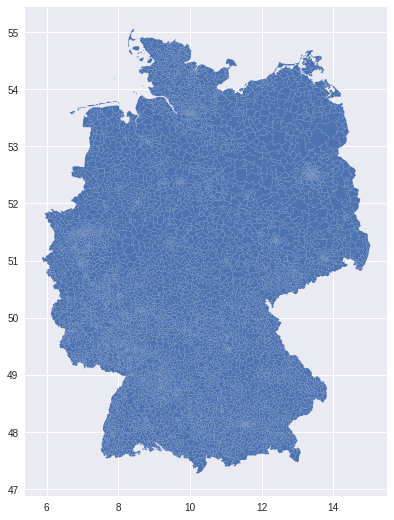

In [ ]:
plz_shape_df["geometry"].plot(figsize=(figure_size,figure_size))
plt.show()

In [ ]:
plz_merged = pd.merge(left= plz_shape_df,right= plz_ort, on = 'plz', how = 'left')

In [ ]:
plz_merged = plz_merged.rename(columns={'ort':'city'})

In [ ]:
#get longitude and latitude. refer: https://medium.com/analytics-vidhya/how-to-generate-lat-and-long-coordinates-of-city-without-using-apis-25ebabcaf1d5
from  geopy.geocoders import Nominatim
geolocator = Nominatim()
def get_geocode(city):
  country ="Germany"
  loc = geolocator.geocode(city+','+ country)
  return loc.longitude, loc.latitude

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [ ]:
packages_per_city['geo'] = packages_per_city['city'].apply(lambda x : get_geocode(x))
packages_per_city['longitude'] = packages_per_city['city'].apply(lambda x : get_geocode(x)[0])
packages_per_city['latitude'] = packages_per_city['city'].apply(lambda x : get_geocode(x)[1])

In [ ]:
# get zipcodes
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']['postcode']


geolocator = geopy.Nominatim(user_agent='my-application')
packages_per_city['plz'] = packages_per_city.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude')
packages_per_city.head(5)

,city,num_packages,federal,percentage,geo,longitude,latitude,plz
0,Berlin,3070,Berlin,85.634589,"(13.3888599, 52.5170365)",13.388860,52.517037,10117
1,Dortmund,280,Nordrhein-Westfalen,7.810321,"(7.4652789, 51.5142273)",7.465279,51.514227,44137
2,Münster,54,Nordrhein-Westfalen,1.506276,"(7.6251879, 51.9625101)",7.625188,51.962510,48143
3,Wetzlar,53,Hessen,1.478382,"(8.5074406, 50.5525346)",8.507441,50.552535,35578
4,Regensburg,41,Bayern,1.143654,"(12.0974869, 49.0195333)",12.097487,49.019533,93047


In [ ]:
#use dict for city and geometry
top_cities = pd.Series(packages_per_city.geo.values,index=packages_per_city.city).to_dict()
top_cities

{'Bad Hersfeld': (9.7068481, 50.8681341),
 'Berlin': (13.3888599, 52.5170365),
 'Bremen': (8.8071646, 53.0758196),
 'Dortmund': (7.4652789, 51.5142273),
 'Düsseldorf': (6.7763137, 51.2254018),
 'Essen': (7.0158171, 51.4582235),
 'Grevenbroich': (6.5835365, 51.0905783),
 'Grünberg': (8.9603407, 50.5913238),
 'Iserlohn': (7.6999713, 51.3746778),
 'Konstanz': (9.1750718, 47.659216),
 'Köln': (6.959974, 50.938361),
 'Mönchengladbach': (6.4353641, 51.1946983),
 'Münster': (7.6251879, 51.9625101),
 'Neuenstein': (9.5803049, 49.2047713),
 'Potsdam': (13.0591397, 52.4009309),
 'Regensburg': (12.0974869, 49.0195333),
 'Stade': (9.475438, 53.599794),
 'Viersen': (6.3905476, 51.2562118),
 'Weil der Stadt': (8.8707147, 48.7501041),
 'Wetzlar': (8.5074406, 50.5525346)}

In [ ]:
#merge
merged_pack_city = pd.merge(
    left=plz_merged, 
    right=pack_per_city, 
    on='city',
    how='left'
)
merged_pack_city['percentage'] = merged_pack_city['percentage'].fillna(0)

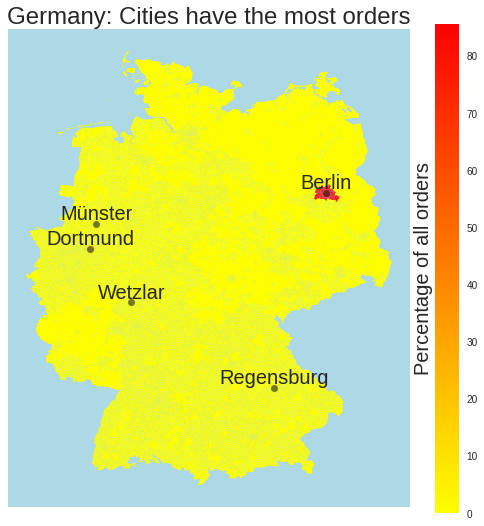

In [ ]:
#plot a map
fig,ax = plt.subplots(figsize=(figure_size,figure_size))

merged_pack_city.plot(
    ax=ax, 
    column='percentage', 
    categorical=False, 
    legend=True,
    cmap='autumn_r',
    alpha=0.9,
)
for c in top_cities.keys():
    if merged_pack_city[merged_pack_city["city"] == c].iloc[0]["percentage"] < 1 :
      continue;

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=my_font_size*2,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(    
    title = 'Germany: Cities have the most orders', 
    xticks = (),
    yticks = (), 
    aspect=1.4, 
    facecolor='lightblue'
);
ax.set_ylabel('Percentage of all orders', fontsize=my_font_size*2)
ax.title.set_size(fontsize=my_font_size*2.4)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.show()

# save the plot as a file for better sharing possibilities
fig.savefig('Cities_have_the_most_order.jpg',
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

**2. Cities have the most users**

In [ ]:
merged_user_city = pd.merge(
    left=plz_merged, 
    right=users_per_city, 
    on='city',
    how='left'
)
merged_user_city['percentage_user'] = merged_user_city['percentage_user'].fillna(0)

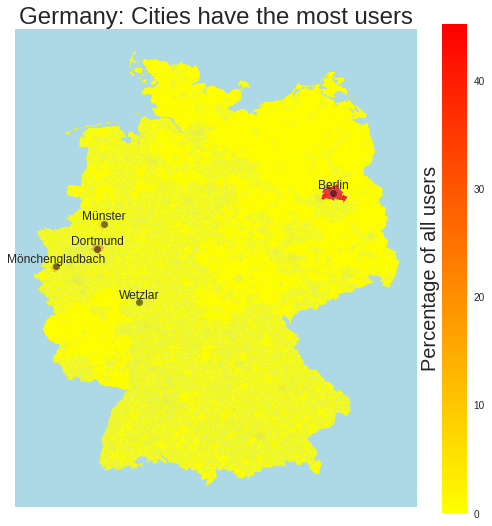

In [ ]:
fig,ax = plt.subplots(figsize=(figure_size,figure_size))

merged_user_city.plot(
    ax=ax, 
    column='percentage_user', 
    categorical=False, 
    legend=True, 
    cmap='autumn_r',
    alpha=0.9,
)
for c in top_cities.keys():
    if merged_user_city[merged_user_city["city"] == c].iloc[0]["percentage_user"] < 4 :
      continue;

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(
    title='Germany: Cities have the most users', 
    aspect=1.4, 
    xticks = (),
    yticks = (),
    facecolor='lightblue'
);
ax.set_ylabel('Percentage of all users', fontsize=my_font_size*2)
ax.title.set_size(fontsize=my_font_size*2.4)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.show()

# save the plot as a file for better sharing possibilities
fig.savefig('Cities_have_the_most_users.jpg',
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

*As we can see, some cities have many users but not many orders and vice versa, which means it might be our depot distribution is not optimal yet.* 

### **3. Number of packages per user**

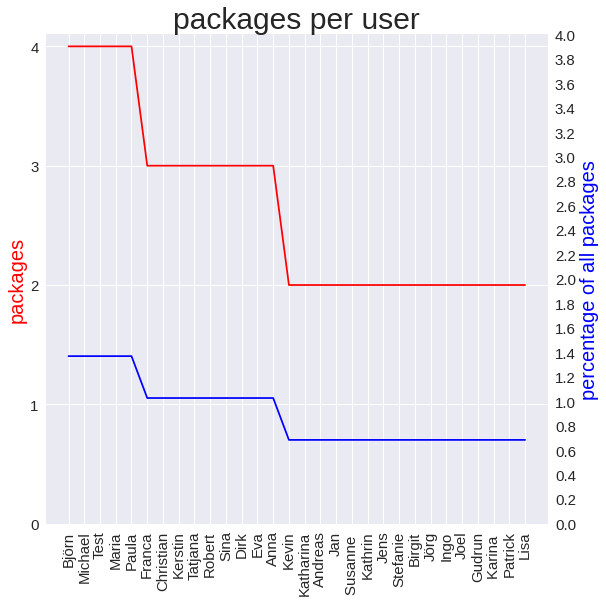

In [ ]:
# Asuming only every username is only used once 
packages_per_sender = users['firstName'].value_counts().to_frame().reset_index(drop=False)
packages_per_sender.columns = ['firstName','num_packages']
# calculating the percentage 
packages_per_sender['percentage'] = packages_per_sender['num_packages']*100/packages_per_sender['num_packages'].sum()
# output for checking
packages_per_sender.head()

# reducing number of shown persons because there are over 200. Show only relevant 20 top customers
packages_per_sender_short = packages_per_sender.iloc[:30]

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(figure_size,figure_size))

# make a plot
ax.plot(packages_per_sender_short.firstName, packages_per_sender_short.num_packages, color="red")

# settings for the packages subplot
# title
ax.set_title("packages per user", fontsize=my_font_size*3)
# set x-axis label to users firstname
ax.set_xticklabels(packages_per_sender_short.firstName, rotation=90,fontsize=my_font_size*2)
ax.tick_params(labelsize = my_font_size*1.5)
# set y-axis label
ax.set_ylabel("packages",fontsize=my_font_size*2,color="red")
# set yticks to integers
ax.set_yticks((0,1,2,3,4))

# twin object for the second y-axis representing percentage 
ax2=ax.twinx()
# turning off the grid to prevent overlapping 
ax2.grid(False)
# make a plot for the second y-axis representig percentage 
ax2.plot(packages_per_sender_short["percentage"],color="blue")
# settings for the percentage subplot
ax2.set_ylabel("percentage of all packages",color="blue",fontsize=my_font_size*2)
ax2.tick_params(labelsize = my_font_size*1.5)
# setting manual yticks to shrink down the percentage graph
ax2.set_yticks((0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0))
plt.show()

# save the plot as a file for better sharing possibilities
fig.savefig('packages_per_user.jpg',
            format='jpeg',
            dpi=300,
            bbox_inches='tight')
